## Rete Neurale
Questo codice carica i tuoi dati pre-elaborati dai file numpy e li converte in tensori PyTorch. Quindi crea i DataLoader per il set di addestramento e validazione e definisce l’architettura della rete neurale. Il modello viene addestrato utilizzando il set di addestramento e la funzione di perdita CrossEntropy per num_epochs epoche. Ad ogni epoca, viene calcolata l’accuratezza del modello sul set di validazione e viene confrontata con la miglior accuratezza finora ottenuta. Se la nuova accuratezza è migliore della precedente (ovvero se è superiore alla precedente di una quantità maggiore di delta_threshold), allora il contatore viene reimpostato a 0 e il modello viene salvato. Altrimenti, il contatore viene incrementato di 1. Se il contatore raggiunge il valore di patience, l’addestramento viene interrotto.

Infine, il codice carica il miglior modello ottenuto durante l’addestramento e lo valuta sul set di test per calcolare l’accuratezza.

# Importo dati e librerie

In [1349]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Carica i dati pre-elaborati
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Converto i dati in tensori PyTorch

In [1350]:
X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()
X_val = torch.tensor(val_features).float()
y_val = torch.tensor(val_labels).long()
X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).long()

# Creo i DataLoader per il set di addestramento e validazione

In [1351]:
# Crea i DataLoader per il set di addestramento e validazione
batch_size = 30
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Definisci l'architettura della rete neurale

In [1352]:
# Definisci l'architettura della rete neurale
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        # Aggiungi un nuovo strato nascosto
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        # Passa i dati attraverso il nuovo strato nascosto
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

# Crea un'istanza del modello

In [1353]:
# Crea un'istanza del modello
model = Net()

# Controlliamo se i dati sono bilanciati

In [1354]:
# Carica le etichette del set di addestramento
train_labels = np.load('Pre_Processed_Data/train_labels.npy')

# Calcola la distribuzione delle etichette
unique_labels, counts = np.unique(train_labels, return_counts=True)
label_distribution = dict(zip(unique_labels, counts))

print(label_distribution)

{0: 349, 1: 188}


# Calcola i pesi per ciascuna classe
Utilizzare i pesi di classe può aiutare a bilanciare l’effetto dello sbilanciamento dei dati durante l’addestramento del modello e può migliorare le prestazioni del modello sui dati sbilanciati.

In [1355]:
# Calcola i pesi per ciascuna classe
class_sample_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weight = 1. / class_sample_count
weight = torch.from_numpy(weight)
weight = weight.float()

 Purtroppo i dati sono sbilanciati, allora abbiamo calcolato i pesi per ciascuna classe utilizzando il reciproco del numero di esempi per ciascuna classe e abbiamo creato un tensore di pesi per ciascuna classe. Quindi, abbiamo passato il tensore di pesi alla funzione di perdita nn.CrossEntropyLoss come parametro weight. In questo modo, gli esempi della classe minoritaria avranno un peso maggiore durante l’addestramento.

# Definisci la funzione di perdita e l'ottimizzatore

In [1356]:
# Definisci la funzione di perdita e l'ottimizzatore con i pesi di classe
criterion = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Definisci la funzione per validare il modello sul set di validazione

In [1357]:
# Definisci la funzione per validare il modello sul set di validazione
def validate_model(model, validation_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy_validation = correct_predictions / total_predictions
    return accuracy_validation

# Definisci le variabili per l'early stopping

In [1358]:
# Definisci le variabili per l'early stopping
best_accuracy_validation = 0  # Valore iniziale per il confronto
patience = 10  # Numero di epoche per tollerare la diminuzione dell'accuratezza sul set di validazione
delta_threshold = 0.0001    # Soglia di miglioramento basata sull'accuratezza sul set di validazione
counter = 0  # Contatore per il numero di epoche senza miglioramento

# Addestra il modello

In [1359]:
# Addestra il modello
num_epochs=1000 
for epoch in range(num_epochs):
    model.train() 
    epoch_loss_sum=0.0 
    for i,(features,labels) in enumerate(train_loader):
        optimizer.zero_grad() 
        outputs=model(features) 
        loss=criterion(outputs,labels) 
        epoch_loss_sum+=loss.item() 
        loss.backward() 
        optimizer.step() 
    epoch_loss_avg=epoch_loss_sum/len(train_loader) 
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')
    
    # Verifica se l'accuratezza corrente sul set di validazione è migliore dell'accuratezza migliore finora
    accuracy_validation=validate_model(model,val_loader) 
    if accuracy_validation-best_accuracy_validation>delta_threshold: 
        best_accuracy_validation=accuracy_validation 
        counter=0 
        torch.save(model.state_dict(),'best_model.pth') 
    else: 
        counter+=1 

    # Stampa l'accuratezza sul set di validazione ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Accuracy on validation set: {accuracy_validation:.4f}')

    if counter>=patience: 
        print(f'Stopping early at epoch {epoch + 1}')
        break

Epoch [1/1000], Loss: 0.6937
Epoch [2/1000], Loss: 0.6941
Epoch [3/1000], Loss: 0.6942


Epoch [4/1000], Loss: 0.6929
Epoch [5/1000], Loss: 0.6935
Epoch [6/1000], Loss: 0.6899
Epoch [7/1000], Loss: 0.6879
Epoch [8/1000], Loss: 0.6914
Epoch [9/1000], Loss: 0.6859
Epoch [10/1000], Loss: 0.6853
Epoch [10/1000], Accuracy on validation set: 0.7130
Epoch [11/1000], Loss: 0.6824
Epoch [12/1000], Loss: 0.6833
Epoch [13/1000], Loss: 0.6789
Epoch [14/1000], Loss: 0.6709
Epoch [15/1000], Loss: 0.6496
Stopping early at epoch 15


# Carica il miglior modello

In [1360]:
# Carica il miglior modello
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Valuta il modello sul set di test

In [1361]:
# Valuta il modello sul set di test
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    _tmp, test_predictions = torch.max(outputs.data, 1)
    accuracy = (test_predictions == y_test).float().mean()
    print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.7241


## Valutazione delle prestazioni sul set di test

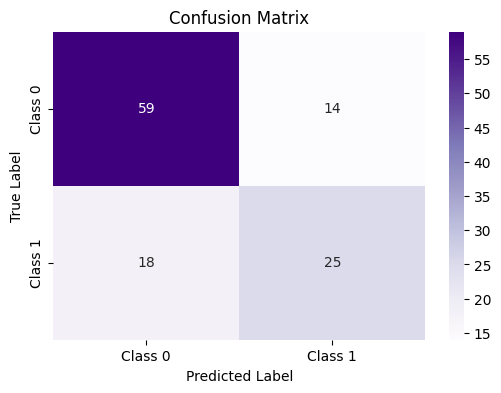

In [1362]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [1363]:
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        73
           1       0.64      0.58      0.61        43

    accuracy                           0.72       116
   macro avg       0.70      0.69      0.70       116
weighted avg       0.72      0.72      0.72       116



AUC: 0.6948072634597006


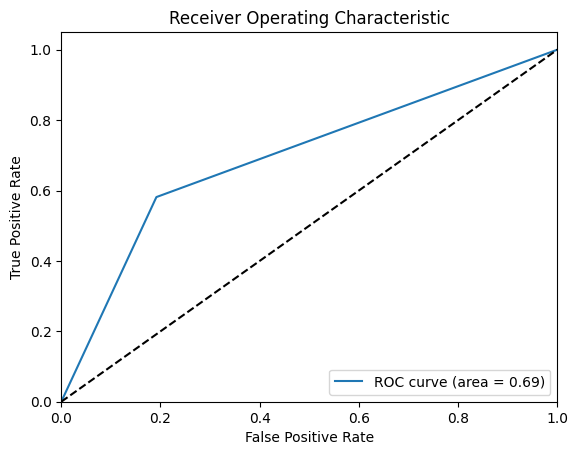

In [1364]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [1365]:
from sklearn.model_selection import KFold

def cross_validate(model, criterion, optimizer, X, y, k=5):
    kfold = KFold(n_splits=k)
    accuracy_scores = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_data = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_data, batch_size=batch_size)

        # Inizializza le variabili per l'early stopping
        best_accuracy_validation = 0
        counter = 0

        for epoch in range(num_epochs):
            model.train()
            epoch_loss_sum = 0.0
            for i,(features,labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                epoch_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            accuracy_validation = validate_model(model,val_loader)
            if accuracy_validation-best_accuracy_validation>delta_threshold:
                best_accuracy_validation=accuracy_validation
                counter=0
                torch.save(model.state_dict(),'best_model.pth')
            else:
                counter+=1

            if counter>=patience:
                break

        model.load_state_dict(torch.load('best_model.pth'))
        accuracy_scores.append(validate_model(model,val_loader))

    return np.mean(accuracy_scores)

# Carica i dati pre-elaborati
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()

# Crea un'istanza del modello
model = Net()

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Esegui la convalida incrociata a 5 parti
accuracy = cross_validate(model, criterion, optimizer, X_train, y_train)
print(f'Accuracy with cross validation: {accuracy:.4f}')


Accuracy with cross validation: 0.6499


Il modello ha un’accuratezza del 72,41% sul set di test. Questo significa che il modello è in grado di classificare correttamente circa il 72,41% dei dati di test. La matrice di confusione mostra che il modello ha classificato correttamente 59 esempi della classe 0 e 25 esempi della classe 1, mentre ha classificato erroneamente 14 esempi della classe 0 come classe 1 e 18 esempi della classe 1 come classe 0.

Il rapporto di classificazione mostra diverse metriche per valutare le prestazioni del modello. La precisione per la classe 0 è 0.77, il che significa che il 77% delle previsioni del modello per la classe 0 sono corrette. La precisione per la classe 1 è 0.64, il che significa che il 64% delle previsioni del modello per la classe 1 sono corrette. Il richiamo per la classe 0 è 0.81, il che significa che il modello ha identificato correttamente l’81% degli esempi della classe 0. Il richiamo per la classe 1 è 0.58, il che significa che il modello ha identificato correttamente il 58% degli esempi della classe 1.

L’area sotto la curva ROC (AUC) è un’altra metrica utilizzata per valutare le prestazioni del modello. Un valore AUC di 1 indica un modello perfetto, mentre un valore AUC di 0.5 indica un modello casuale. Nel tuo caso, l’AUC è 0.69, il che indica che il modello ha prestazioni migliori rispetto a un modello casuale.

Infine, l’accuratezza con la cross validation è 0.6499, il che indica che le prestazioni del modello sono stabili quando viene addestrato su diverse parti dei dati.

In generale, possiamo dire che questi risultati mostrano che il modello ha una buona capacità di classificare i dati di test e ha prestazioni stabili quando viene addestrato su diverse parti dei dati.